# EPICSCORE illustration for quantile regression

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from Epistemic_CP.utils import QuantileRegressionNN
import torch
from sklearn.model_selection import train_test_split
import pymc as pm
import pymc_bart as pmb
import arviz as az

Fitting quantile regression:

In [33]:
# Generate X from a mixture of Gaussians
rng = np.random.default_rng(42)
torch.cuda.manual_seed(45)
torch.manual_seed(45)
# Font size
plt.rcParams.update({"font.size": 30})
# Enable LaTeX rendering in matplotlib
plt.rcParams["text.usetex"] = True

def generate_function(n, rng, loc_1=2, loc_2=6.5, scale_1=0.5, scale_2=1):
    X1 = rng.normal(loc=loc_1, scale=scale_1, size=n // 2)
    X2 = rng.normal(loc=loc_2, scale=scale_2, size=n // 2)
    X = np.concatenate([X1, X2])
    rng.shuffle(X)
    # Define the true relationship between X and Y
    Y_true = np.sin(X) + 0.1 * X

    # Add heteroscedastic noise (aleatoric uncertainty)
    noise = rng.normal(0, 0.2 * np.abs(np.sin(X)), size=n)
    Y = Y_true + noise

    return X.reshape(-1, 1), Y


X, Y = generate_function(n=300, rng=rng)
X_test, Y_test = generate_function(n=300, rng=rng)

# Define quantiles
alpha = 0.1

# Initialize the model
regressor = QuantileRegressionNN(
    quantiles=[alpha / 2, 1 - (alpha / 2)],
    undo_quantile_crossing=False,
)

# Fit the model
regressor.fit(X.reshape(-1, 1), Y)

# compute marginal coverage for the test set
quantiles_test = regressor.predict(X_test)
q_low_test = quantiles_test[:, 0]
q_high_test = quantiles_test[:, 1]
coverage = np.mean((Y_test >= q_low_test) & (Y_test <= q_high_test))
print(f"Marginal Coverage: {coverage:.3f} (Target: {1 - alpha:.3f})")

Marginal Coverage: 0.860 (Target: 0.900)


Plotting uncalibrated quantile regression model:

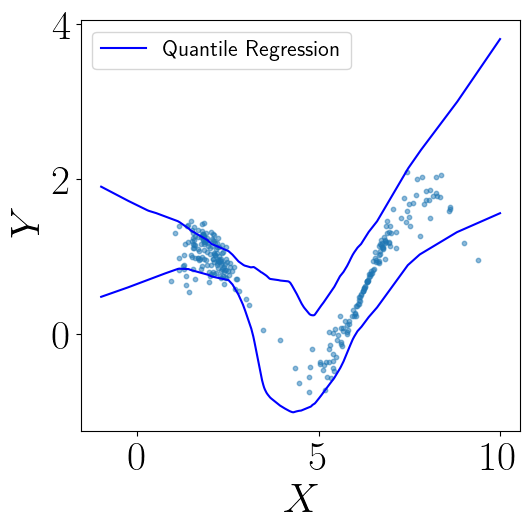

In [34]:
# Predict quantiles for new data
X_grid = np.linspace(-1, 10, 1000)
quantiles = regressor.predict(X_grid.reshape(-1, 1))

# Extract quantiles
q_low = quantiles[:, 0]
q_high = quantiles[:, 1]

# First Plot
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, s=10, alpha=0.5)
plt.plot(X_grid, q_low, color="blue", label="Quantile Regression")
plt.plot(X_grid, q_high, color="blue")
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.tight_layout()
# Move the legend outside the graph
plt.legend(fontsize=16)
plt.show()

Fitting CQR:

In [35]:
# calibration step
X_calib, y_calib = generate_function(n=1000, rng=rng)
# computing scores
pred = regressor.predict(X_calib)
scores_calib = np.max(
    np.column_stack((pred[:, 0] - y_calib, y_calib - pred[:, 1])), axis=1
)
# cqr method
n = scores_calib.shape[0]
t_cqr = np.quantile(scores_calib, np.ceil((n + 1) * (1 - alpha)) / n)

PLotting CQR prediction band:

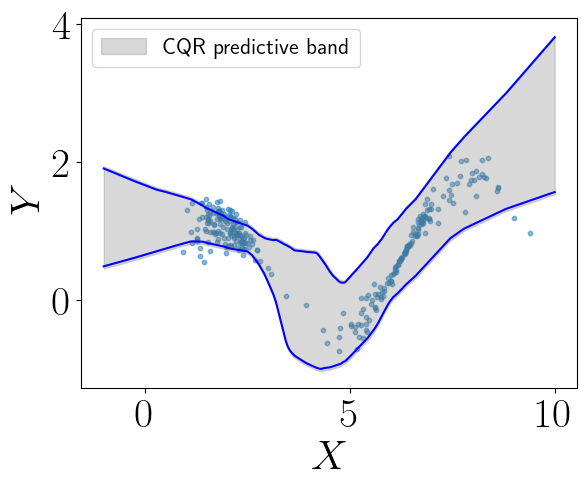

In [36]:
# plotting cqr predictive region
plt.scatter(X, Y, s=10, alpha=0.5)
plt.plot(X_grid, q_low, color="blue")
plt.plot(X_grid, q_high, color="blue")
plt.fill_between(
    X_grid.flatten(),
    q_low - t_cqr,
    q_high + t_cqr,
    color="gray",
    alpha=0.3,
    label="CQR predictive band",
)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.legend(fontsize = 16)
plt.show()


Calibration step:

In [37]:
# splitting scores_calib
(
    X_calib_train,
    X_calib_test,
    scores_calib_train,
    scores_calib_test,
) = train_test_split(
    X_calib,
    scores_calib,
    test_size=0.3,
    random_state=15,
)

Plotting conformal scores:

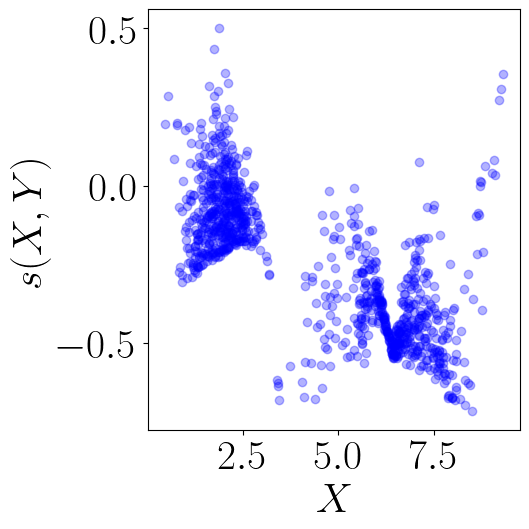

In [38]:
# plotting scores
plt.figure(figsize=(6, 6))
plt.scatter(
    X_calib.flatten(),
    scores_calib,
    color="blue",
    label="Training scores",
    alpha=0.3,
)

plt.xlabel("$X$")
plt.ylabel(r"$s(X, Y)$")
plt.tight_layout()
plt.show()

Fitting EPICSCORE-bart by hand:

In [39]:
n_obs = X_calib_train.shape[0]
# based on BART
# heteroscedastic BART
model_bart = pm.Model()
# generating posterior samples
with model_bart:
    data_X = pm.Data(
        "data_X",
        X_calib_train,
    )
    Y_used = scores_calib_train

    w = pmb.BART(
        "w",
        data_X,
        Y_used,
        m=100,
        shape=(2, n_obs),
    )

    pm.Normal(
        "s_pred",
        mu=w[0],
        sigma=np.exp(w[1]),
        shape=data_X.shape[0],
        observed=Y_used,
    )
    

    mc_sample = pm.sample(
        draws = 500,
        chains=4,
        random_seed=rng,
        cores=6,
    )

# generating predictive samples
with model_bart:
    data_X.set_value(X_calib_test)

    posterior_predictive_test = pm.sample_posterior_predictive(
        trace=mc_sample,
        random_seed=rng,
        var_names=["s_pred"],
        predictions=True,
    )

pps_calib = az.extract(
    posterior_predictive_test, 
    group="predictions", 
    var_names=["s_pred"]
).T.to_numpy()

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [s_pred, w]


Output()

Obtaining cutoffs on transformed scores:

In [40]:
# obtaining cutoff
cdf_array = np.mean((np.subtract(pps_calib, scores_calib_test) <= 0) + 0, axis=0)

n = scores_calib_test.shape[0]
#  transformed cutoff
t_cutoff = np.quantile(cdf_array, np.ceil((n + 1) * (1 - alpha)) / n)

# predicting
with model_bart:
    data_X.set_value(X_grid.reshape(-1, 1))

    posterior_predictive_grid = pm.sample_posterior_predictive(
        trace=mc_sample,
        random_seed=rng,
        var_names=["s_pred"],
        predictions=True,
    )

pps_grid = az.extract(
    posterior_predictive_grid,
    group="predictions",
    var_names=["s_pred"],
).T.to_numpy()

lower_scores = np.quantile(pps_grid, q=(0.05 / 2), axis=0)
upper_scores = np.quantile(pps_grid, q=(1 - (0.05 / 2)), axis=0)

cutoffs = np.quantile(pps_grid, q=t_cutoff, axis=0)

Sampling: [s_pred, w]


Output()

Plotting scores predictive region with versus predictive-based cutoffs:

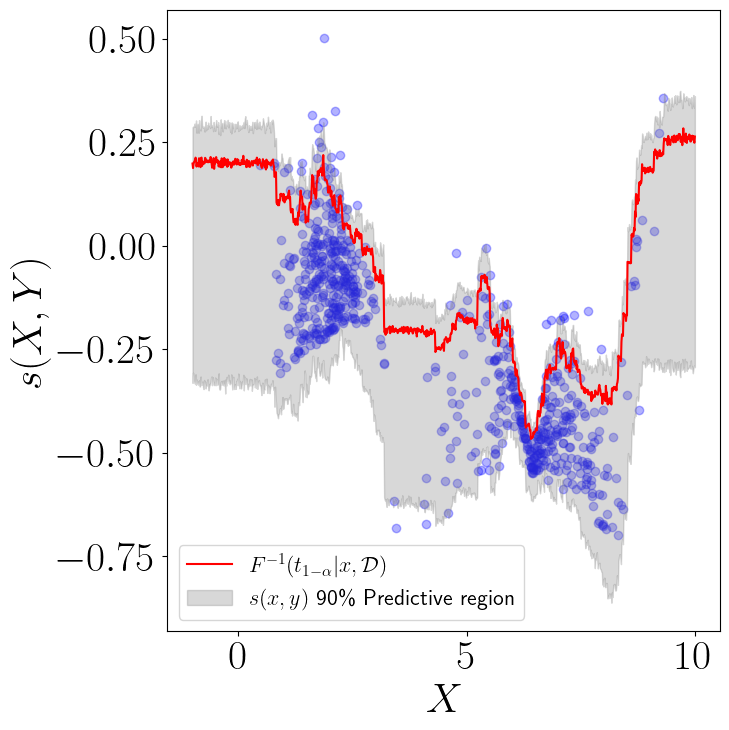

In [41]:
# plotting scores predictive region and cutoff lines
plt.figure(figsize=(8, 8))
plt.scatter(
    X_calib_train.flatten(),
    scores_calib_train,
    color="blue",
    alpha=0.3,
)
plt.plot(
    X_grid,
    cutoffs,
    color="red",
    label=r"$F^{-1}(t_{1-\alpha}|x,\mathcal{D})$",
)
plt.fill_between(
    X_grid.flatten(),
    lower_scores,
    upper_scores,
    color="gray",
    alpha=0.3,
    label=r"$s(x,y)$ 90\% Predictive region",
)
plt.xlabel("$X$")
plt.ylabel(r"$s(X, Y)$")
plt.tight_layout()
plt.legend(fontsize=16)
plt.show()

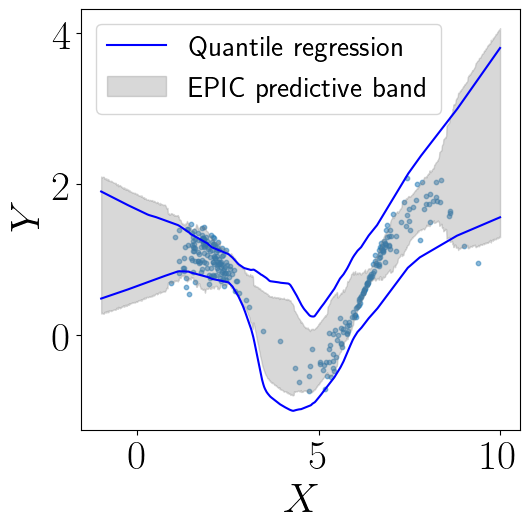

In [43]:
plt.figure(figsize=(6, 6))
plt.scatter(X.flatten(), Y, s=10, alpha=0.5)
plt.plot(X_grid, q_low, color="blue", label="Quantile regression")
plt.plot(X_grid, q_high, color="blue")
plt.fill_between(
    X_grid.flatten(),
    q_low - cutoffs,
    q_high + cutoffs,
    color="gray",
    alpha=0.3,
    label="EPIC predictive band",
)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.legend(fontsize=21)
plt.tight_layout()
plt.show()